In [113]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit, jit

In [114]:
from numba.np.extensions import cross2d
# from sec_cross import is_crossing

class Track:
    def __init__(self, walls:np.ndarray, stop:np.ndarray):
        self.walls = walls
        self.start = (0, 0)
        self.stop = stop

    # https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect
    def is_crossing(self, vector:np.ndarray):
        return self._is_crossing(self.walls, vector)
        # for wall in self.walls:
        #     if is_crossing(wall, vector):
        #         return True
        

    def is_finishing(self, vector:np.ndarray):
        return self._is_finishing(self.stop, vector)
        # return is_crossing(self.stop, vector)
    
    @staticmethod
    @njit
    def _is_crossing(walls, vector):
        for wall in walls:
            p = wall[0]
            q = vector[0]

            r = wall[1] - wall[0]
            s = vector[1] - vector[0]

            rs_cross = cross2d(r, s)
            qpr_cross = cross2d(q-p, r)

            if rs_cross == 0 and qpr_cross == 0:
                t0 = np.dot(q-p, r) / np.dot(r, r)
                t1 = np.dot(s, r) / np.dot(r, r) + t0
                if (t0 > 0 and t0 < 1) or (t1 > 0 and t1 < 1) or (t0 < 0 and t1 > 1) or (t1 < 0 and t0 > 1):
                    return True
            elif rs_cross != 0:
                t = cross2d(q-p, s) / rs_cross
                u = qpr_cross / rs_cross
                if (t > 0 and t < 1 and u > 0 and u < 1):
                    return True
        
        return False
    
    @staticmethod
    @njit
    def _is_finishing(stop, vector):
        p = stop[0]
        q = vector[0]

        r = stop[1] - stop[0]
        s = vector[1] - vector[0]

        rs_cross = cross2d(r, s)
        qpr_cross = cross2d(q-p, r)

        if rs_cross == 0 and qpr_cross == 0:
            t0 = np.dot(q-p, r) / np.dot(r, r)
            t1 = np.dot(s, r) / np.dot(r, r) + t0
            if (t0 > 0 and t0 < 1) or (t1 > 0 and t1 < 1) or (t0 < 0 and t1 > 1) or (t1 < 0 and t0 > 1):
                return True
        elif rs_cross != 0:
            t = cross2d(q-p, s) / rs_cross
            u = qpr_cross / rs_cross
            if (t > 0 and t < 1 and u > 0 and u < 1):
                return True
        
        return False
            

In [115]:
class Chrom:
    # genes: list

    code = {1 : (-1, -1), 
            2 : (0, -1),
            3 : (1, -1), 
            4 : (-1, 0), 
            5 : (0, 0), 
            6 : (1, 0), 
            7 : (-1, 1), 
            8 : (0, 1), 
            9 : (1, 1)}
    
    inv_code = dict(map(reversed, code.items()))

    def __init__(self, genes, off_track_pen, finish_rew):
        self.genes = genes
        self.loss = 0
        self.off_track_pen = off_track_pen
        self.finish_rew = finish_rew

    def update_loss(self, track:Track):
        loss = 0
        poss = self.get_poss()
        out_of_track = False
        finished = False
        for i in range(1, len(poss)):
            if track.is_crossing(np.array([poss[i], poss[i-1]])):  
                out_of_track = not out_of_track
            if out_of_track:
                loss += math.pow(self.off_track_pen, i)
            if not out_of_track and not finished and track.is_finishing(np.array([poss[i], poss[i-1]])):
                finished = True
                loss -= math.pow(self.finish_rew, i)
        
        print(loss)
        self.loss = loss

    def get_vectors_from_changes(self, start:np.ndarray) -> list:
        # vectors = []
        # curr_pos = np.array(start)
        # for i in range(len(self.genes)):
        #     np.array([curr_pos])
        pass

    def get_poss(self):
        changes = np.array(self.decode(self.genes))
        _vel = np.array([0, 0])
        _curr_pos = np.array([0, 0])
        poss = np.zeros((len(changes) + 1, 2), dtype=np.float64)
        poss[0] = _curr_pos
        for i in range(len(changes)):
            _vel += changes[i]
            _curr_pos += _vel
            poss[i+1] = _curr_pos
        return poss

    def decode(self, code):
        return np.array([self.code.get(c) for c in code])
    
    def __len__(self):
        return len(self.genes)
    
    def __getitem__(self, i):
        return self.genes[i]
    
    def __setitem__(self, key, item):
        self.genes[key] = item

In [116]:
import random

class Population:
    # chroms: ndarray

    decoder = {1 : (-1, -1), 
            2 : (0, -1),
            3 : (1, -1), 
            4 : (-1, 0), 
            5 : (0, 0), 
            6 : (1, 0), 
            7 : (-1, 1), 
            8 : (0, 1), 
            9 : (1, 1)}
    coder = dict(map(reversed, decoder.items()))

    def __init__(self, npop, l_min, l_max, track:Track, off_track_pen, finish_rew, p_mute:tuple):
        self.npop = npop
        self.track = track
        self.off_track_pen = off_track_pen
        self.finish_rew = finish_rew
        self.chroms:list[Chrom] = self.generate_pop(npop, l_min, l_max)
        self.p_mute = p_mute
        self.best_so_far = self.get_best()
        self.best_hist = []
        self.best_hist.append(self.best_so_far)

    def generate_pop(self, npop, l_min, l_max):
        chroms = np.empty(npop, dtype=Chrom)
        for i in range(npop):
            l = np.random.randint(l_min, l_max)
            chrom_genes = np.random.randint(3, size=(l, 2)) - 1
            chrom = Chrom(genes = self.encode(chrom_genes), off_track_pen=self.off_track_pen, finish_rew = self.finish_rew)
            chroms[i] = chrom
            chrom.update_loss(track = self.track)
        return chroms
    
    def next_gen(self):
        costs = np.array([c.loss for c in self.chroms])
        parent1 = self.select_parent(costs)
        parent2 = self.select_parent(costs)
        self.replace_with_children(parent1, parent2)
        self.mutate()

        # if curr_best.loss < self.best_so_far.loss:
        #     self.best_hist.append(curr_best)
        #     self.best_so_far = curr_best

    def select_parent(self, costs):
        # Transform costs to non-negative values
        min_cost = min(costs)
        transformed_costs = [cost - min_cost for cost in costs]

        # Calculate total inverse cost (to give higher probability to lower transformed costs)
        total_inverse_cost = sum(1 / (1 + cost) for cost in transformed_costs)

        # Generate a random number between 0 and the total inverse cost
        spin = random.uniform(0, total_inverse_cost)

        # Roulette wheel selection
        cumulative_inverse_cost = 0.0
        selected_index = None

        for i, cost in enumerate(transformed_costs):
            cumulative_inverse_cost += 1 / (1 + cost)
            if cumulative_inverse_cost >= spin:
                selected_index = i
                break

        return self.chroms[selected_index]

    def replace_with_children(self, parent1, parent2):
        min_length = min(len(parent1), len(parent2))
        c_point = random.randint(1, min_length - 1)

        # Perform crossover point-wise
        temp = np.copy(parent1[:c_point])
        parent1[:c_point] = parent2[:c_point]
        parent2[:c_point] = temp
        parent1.update_loss(self.track)
        parent2.update_loss(self.track)

    def mutate(self):
        # self._mutate([chrom.genes for chrom in self.chroms], self.track, self.p_mute)
        chance = random.random()
        for chrom in self.chroms:
            ## up mutation
            if chance < self.p_mute[0]:
                gene_idx = random.randint(0, len(chrom)-1)
                if chrom[gene_idx] < 7:
                    chrom[gene_idx] += 3
                    chrom.update_loss(self.track)

            ## right mutation
            if chance < self.p_mute[1]:
                gene_idx = random.randint(0, len(chrom)-1)
                if chrom[gene_idx] % 3 != 0:
                    chrom[gene_idx] += 1
                    chrom.update_loss(self.track)

            ## down mutation
            if chance < self.p_mute[2]:
                gene_idx = random.randint(0, len(chrom)-1)
                if chrom[gene_idx] > 3:
                    chrom[gene_idx] -= 3
                    chrom.update_loss(self.track)

            ## left mutation
            if chance < self.p_mute[3]:
                gene_idx = random.randint(0, len(chrom)-1)
                if chrom[gene_idx] % 3 != 1:
                    chrom[gene_idx] -= 1
                    chrom.update_loss(self.track)

    def get_best(self) -> Chrom:
        argmin = np.argmin([c.loss for c in self.chroms])
        return self.chroms[argmin]
    
    def encode(self, changes):
        return [self.coder.get(tuple(change)) for change in changes]
    
    def decode(self, code):
        return [list(self.decoder.get(c)) for c in code]
    
    def __repr__(self):
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_aspect('equal')
        for wall in self.track.walls:
            ax.plot(wall[:, 0], wall[:, 1], 'k-', linewidth=2)
        ax.scatter(self.track.start[0], self.track.start[1])
        ax.plot(self.track.stop[:, 0], self.track.stop[:, 1], linewidth = 4)
        vectors = self.best_so_far.get_poss()
        ax.plot(vectors[:, 0], vectors[:, 1], 'ob-', linewidth=1, markersize = 3)
        ax.set_xticks(np.arange(-1, 23))
        ax.set_yticks(np.arange(-5, 10))
        ax.grid()
        # ax.set_xticks(list(range(self.track.start[0], self.track.stop[0])))
        return ""  

2.186625
2.186625
0
0
0
2.186625
0
0
2.186625
1.3366249999999997


100%|██████████| 40/40 [00:00<00:00, 1819.71it/s]

0
0
0.6141249999999999
0.6141249999999999
0.6141249999999999
2.186625
0
2.186625
2.186625
0
0
0
1.3366249999999997
0
0
0
0
2.186625
1.3366249999999997
2.186625
2.186625
2.186625
2.186625
2.186625
2.186625
2.186625
2.186625
2.186625
1.5724999999999998
1.5724999999999998
0
0
2.186625
1.3366249999999997
0
0
2.186625
2.186625
2.186625
1.5724999999999998
1.5724999999999998
2.186625
2.186625
1.3366249999999997
1.3366249999999997
2.186625
2.186625
2.186625
2.186625
2.186625
2.186625
2.186625
1.3366249999999997
1.3366249999999997
1.5724999999999998
2.186625
0
0
0
2.186625
2.186625
1.3366249999999997
1.3366249999999997
0
0
1.3366249999999997
0
2.186625
2.186625
2.186625
1.5724999999999998
2.186625
2.186625
2.186625
0
0
0
2.186625
1.3366249999999997
1.3366249999999997
2.186625
1.3366249999999997
1.3366249999999997
0
0
2.186625
0
2.186625
0
2.186625
2.186625
2.186625
2.186625
0
0
0
0
0
0
1.5724999999999998
0
0.6141249999999999
0.6141249999999999
2.186625
2.186625
2.186625
1.3366249999999997
1.336

''

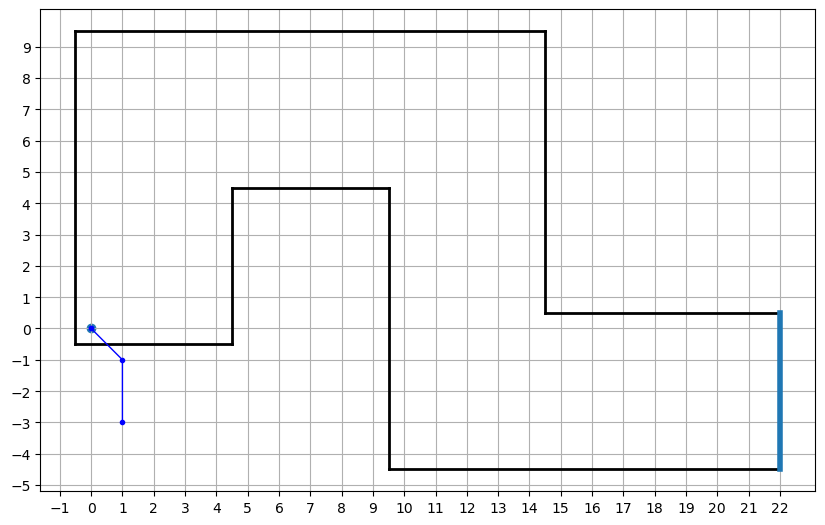

In [120]:
stop=np.array([[22, -4.5], [22, 0.5]], dtype=np.float64)
walls = np.array(
              [[[-0.5, -0.5], [4.5, -0.5]],
                [[-0.5, -0.5], [-0.5, 9.5]],
               [[-0.5, 9.5], [14.5, 9.5]],
               [[14.5, 9.5], [14.5, 0.5]],
               [[14.5, 0.5], [22, 0.5]],
               [[4.5, -0.5], [4.5, 4.5]],
               [[4.5, 4.5], [9.5, 4.5]],
               [[9.5, 4.5], [9.5, -4.5]],
               [[9.5, -4.5], [22, -4.5]]
               ], dtype=np.float64)

track = Track(stop = stop, walls = walls)

npop = 10

pop = Population(npop=npop, l_min=3, l_max=4, track = track, off_track_pen=0.85, finish_rew = 0.9, p_mute = (0.07, 0.07, 0.07, 0.07))
for t in tqdm(range(4 * npop)):
  pop.next_gen()
  if t % (npop // 2) == 0:
    pop.best_so_far = pop.get_best()
repr(pop) 